In [1]:
import numpy as np
import torch
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn
import sys
seaborn.set()

import warnings
warnings.filterwarnings("ignore")

import reservoir
import computekernel
from reckernel import RecKernel
from kuramoto import KS
%load_ext autoreload
%autoreload 2

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Kuramoto data generation and kernel test

In [2]:
L    = 6
N    = 100
dt   = 0.25
ninittransients = 1000
tend = 5000 + ninittransients*dt  #50000
dns  = KS(L=L, N=N, dt=dt, tend=tend)

N_data_train = 10000
N_data_test = 10000

dns.simulate()
u = dns.uu[ninittransients:] / np.sqrt(N)
[u_train, u_test, _] = np.split(u, [N_data_train, N_data_train+N_data_test], axis=0)

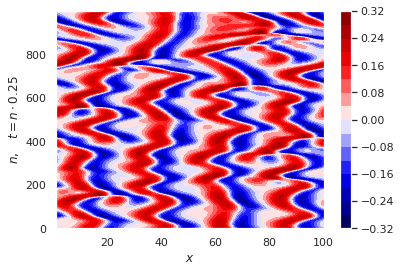

In [3]:
N_plot = 1000
u_plot = u[:N_plot,:]
N_plot = np.shape(u_plot)[0]
# Plotting the contour plot
fig = plt.subplots()
# t, s = np.meshgrid(np.arange(N_plot)*dt, np.array(range(N))+1)
n, s = np.meshgrid(np.arange(N_plot), np.array(range(N))+1)
plt.contourf(s, n, np.transpose(u_plot), 15, cmap=plt.get_cmap("seismic"))
plt.colorbar()
plt.xlabel(r"$x$")
plt.ylabel(r"$n, \quad t=n \cdot {:}$".format(dt));

#     plt.savefig(base_path + "/Figures/Plot_U_first_N{:d}.png".format(N_plot), bbox_inches="tight")
#     plt.close()

In [4]:
def gaussian_data(n_input, input_len_max, input_dim, fix_seed=False):
    if fix_seed == True:
        torch.manual_seed(42)
    return torch.randn(n_input, input_len_max, input_dim).to(device) / np.sqrt(input_dim)

# Arcsin kernel and RC

In [13]:
input_len_range = np.arange(start=1, stop=20, step=1)
n_res_range = np.logspace(2, 4, num=20, dtype=int)
error_rc_asin = torch.zeros(len(input_len_range), len(n_res_range))
input_scale = 1  # variance of input
res_scale = 1 # variance of reservoir

n_input = 50 # number of time series
# input_len = 40 # time steps t
input_dim = 100 #dimension of the time series

loss = torch.nn.MSELoss()
RK = RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)
    
for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                          f='erf', random_projection='gaussian')
    for j, input_len in (enumerate(input_len_range)):
        torch.manual_seed(123)
        input_data = gaussian_data(n_input, input_len, input_dim)

        K = RK.forward(input_data)
        X_final = torch.zeros((n_input,n_res)).to(device)
        
        for n_in in range(n_input):
            X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
            X_final[n_in,:] = X[-1,:]

        K_hat = torch.matmul(X_final,X_final.t())
        error_rc_asin[j, i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

20it [01:13,  3.70s/it]


In [14]:
np.save('out/200519_conv_rc_asin_len1to20_nres1e2to1e4_in1res1', error_rc_asin)

In [15]:
input_len_range = np.arange(start=1, stop=20, step=1)
n_res_range = np.logspace(2, 4, num=20, dtype=int)
error_rc_asin = torch.zeros(len(input_len_range), len(n_res_range))
input_scale = 0.25  # variance of input
res_scale = 1 # variance of reservoir

n_input = 50 # number of time series
# input_len = 40 # time steps t
input_dim = 100 #dimension of the time series

loss = torch.nn.MSELoss()
RK = RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)
    
for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                          f='erf', random_projection='gaussian')
    for j, input_len in (enumerate(input_len_range)):
        torch.manual_seed(123)
        input_data = gaussian_data(n_input, input_len, input_dim)

        K = RK.forward(input_data)
        X_final = torch.zeros((n_input,n_res)).to(device)
        
        for n_in in range(n_input):
            X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
            X_final[n_in,:] = X[-1,:]

        K_hat = torch.matmul(X_final,X_final.t())
        error_rc_asin[j, i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

20it [01:13,  3.70s/it]


In [16]:
np.save('out/200519_conv_rc_asin_len1to20_nres1e2to1e4_in025res1', error_rc_asin)

In [17]:
input_len_range = np.arange(start=1, stop=20, step=1)
n_res_range = np.logspace(2, 4, num=20, dtype=int)
error_rc_asin = torch.zeros(len(input_len_range), len(n_res_range))
input_scale = 0.5  # variance of input
res_scale = 1 # variance of reservoir

n_input = 50 # number of time series
# input_len = 40 # time steps t
input_dim = 100 #dimension of the time series

loss = torch.nn.MSELoss()
RK = RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)
    
for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                          f='erf', random_projection='gaussian')
    for j, input_len in (enumerate(input_len_range)):
        torch.manual_seed(123)
        input_data = gaussian_data(n_input, input_len, input_dim)

        K = RK.forward(input_data)
        X_final = torch.zeros((n_input,n_res)).to(device)
        
        for n_in in range(n_input):
            X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
            X_final[n_in,:] = X[-1,:]

        K_hat = torch.matmul(X_final,X_final.t())
        error_rc_asin[j, i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

20it [01:13,  3.70s/it]


In [18]:
np.save('out/200519_conv_rc_asin_len1to20_nres1e2to1e4_in05res1', error_rc_asin)

In [19]:
input_len_range = np.arange(start=1, stop=20, step=1)
n_res_range = np.logspace(2, 4, num=20, dtype=int)
error_rc_asin = torch.zeros(len(input_len_range), len(n_res_range))
input_scale = 1  # variance of input
res_scale = 0.25 # variance of reservoir

n_input = 50 # number of time series
# input_len = 40 # time steps t
input_dim = 100 #dimension of the time series

loss = torch.nn.MSELoss()
RK = RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)
    
for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                          f='erf', random_projection='gaussian')
    for j, input_len in (enumerate(input_len_range)):
        torch.manual_seed(123)
        input_data = gaussian_data(n_input, input_len, input_dim)

        K = RK.forward(input_data)
        X_final = torch.zeros((n_input,n_res)).to(device)
        
        for n_in in range(n_input):
            X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
            X_final[n_in,:] = X[-1,:]

        K_hat = torch.matmul(X_final,X_final.t())
        error_rc_asin[j, i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

20it [01:14,  3.70s/it]


In [20]:
np.save('out/200519_conv_rc_asin_len1to20_nres1e2to1e4_in1res025', error_rc_asin)

In [21]:
input_len_range = np.arange(start=1, stop=20, step=1)
n_res_range = np.logspace(2, 4, num=20, dtype=int)
error_rc_asin = torch.zeros(len(input_len_range), len(n_res_range))
input_scale = 0.25  # variance of input
res_scale = 0.25 # variance of reservoir

n_input = 50 # number of time series
# input_len = 40 # time steps t
input_dim = 100 #dimension of the time series

loss = torch.nn.MSELoss()
RK = RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)
    
for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                          f='erf', random_projection='gaussian')
    for j, input_len in (enumerate(input_len_range)):
        torch.manual_seed(123)
        input_data = gaussian_data(n_input, input_len, input_dim)

        K = RK.forward(input_data)
        X_final = torch.zeros((n_input,n_res)).to(device)
        
        for n_in in range(n_input):
            X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
            X_final[n_in,:] = X[-1,:]

        K_hat = torch.matmul(X_final,X_final.t())
        error_rc_asin[j, i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

20it [01:13,  3.70s/it]


In [22]:
np.save('out/200519_conv_rc_asin_len1to20_nres1e2to1e4_in025res025', error_rc_asin)

In [23]:
input_len_range = np.arange(start=1, stop=20, step=1)
n_res_range = np.logspace(2, 4, num=20, dtype=int)
error_rc_asin = torch.zeros(len(input_len_range), len(n_res_range))
input_scale = 1  # variance of input
res_scale = 4 # variance of reservoir

n_input = 50 # number of time series
# input_len = 40 # time steps t
input_dim = 100 #dimension of the time series

loss = torch.nn.MSELoss()
RK = RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)
    
for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                          f='erf', random_projection='gaussian')
    for j, input_len in (enumerate(input_len_range)):
        torch.manual_seed(123)
        input_data = gaussian_data(n_input, input_len, input_dim)

        K = RK.forward(input_data)
        X_final = torch.zeros((n_input,n_res)).to(device)
        
        for n_in in range(n_input):
            X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
            X_final[n_in,:] = X[-1,:]

        K_hat = torch.matmul(X_final,X_final.t())
        error_rc_asin[j, i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

20it [01:13,  3.70s/it]


In [24]:
np.save('out/200519_conv_rc_asin_len1to20_nres1e2to1e4_in1res4', error_rc_asin)

In [25]:
input_len_range = np.arange(start=1, stop=20, step=1)
n_res_range = np.logspace(2, 4, num=20, dtype=int)
error_rc_asin = torch.zeros(len(input_len_range), len(n_res_range))
input_scale = 0.25  # variance of input
res_scale = 4 # variance of reservoir

n_input = 50 # number of time series
# input_len = 40 # time steps t
input_dim = 100 #dimension of the time series

loss = torch.nn.MSELoss()
RK = RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)
    
for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                          f='erf', random_projection='gaussian')
    for j, input_len in (enumerate(input_len_range)):
        torch.manual_seed(123)
        input_data = gaussian_data(n_input, input_len, input_dim)

        K = RK.forward(input_data)
        X_final = torch.zeros((n_input,n_res)).to(device)
        
        for n_in in range(n_input):
            X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
            X_final[n_in,:] = X[-1,:]

        K_hat = torch.matmul(X_final,X_final.t())
        error_rc_asin[j, i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

20it [01:13,  3.70s/it]


In [26]:
np.save('out/200519_conv_rc_asin_len1to20_nres1e2to1e4_in025res4', error_rc_asin)

# Arcsin and SRC

In [8]:
n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
input_scale = 1  # variance of input
res_scale = 1 # variance of reservoir

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

RK = RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

# n_res_range = np.arange(start=10000,stop=100000, step=5000)
first_pow = 8
last_pow = 22  # 2**20 => ~10^6
n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
error_src_asin = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
#     K = computekernel.arcsin(input_data, initial_state, scale_res)
    K = RK.forward(input_data)
    X_final = torch.zeros((n_input,n_res)).to(device)
    for n_in in range(n_input):
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='erf', random_projection='structured')
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_src_asin[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

15it [00:24,  1.65s/it]


Text(0, 0.5, 'MSE')

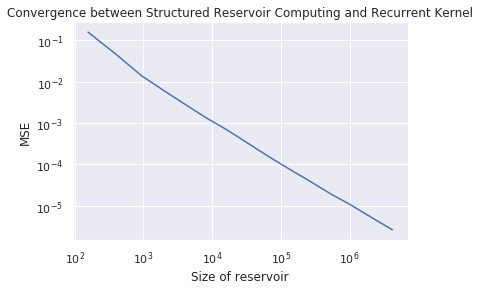

In [9]:
plt.loglog(n_res_range, error_src_asin.numpy())
plt.title('Convergence between Structured Reservoir Computing and Recurrent Kernel');
plt.xlabel('Size of reservoir')
plt.ylabel('MSE')

In [10]:
np.save('out/200519_conv_src_asin_len40_2p8to2p22', error_src_asin)

# RBF kernel and RC

In [11]:
n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
input_scale = 1  # variance of input
res_scale = 1 # variance of reservoir

RK = RecKernel(function='rbf', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

# n_res_range = np.arange(start=100,stop=8000, step=1000)
n_res_range = np.logspace(2, 4, num=20, dtype=int)
error_rc_rbf = torch.zeros(len(n_res_range))

with torch.no_grad():
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    #     K = computekernel.arcsin(input_data, initial_state, scale_res)
        K = RK.forward(input_data)
        X_final = torch.zeros((n_input,n_res)).to(device)
        for n_in in range(n_input):
            model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='cos_rbf', random_projection='gaussian')
            X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
            X_final[n_in,:] = X[-1,:]
            del X

        del model
        K_hat = torch.matmul(X_final,X_final.t())
        error_rc_rbf[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

18it [00:57,  3.19s/it]


RuntimeError: CUDA out of memory. Tried to allocate 236.00 MiB (GPU 0; 10.76 GiB total capacity; 8.57 GiB already allocated; 104.19 MiB free; 9.80 GiB reserved in total by PyTorch)

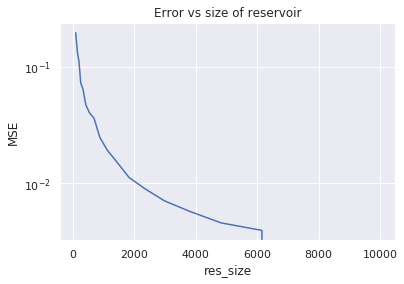

In [12]:
plt.semilogy(n_res_range, error_rc_rbf.numpy())
plt.title('Error vs size of reservoir')
plt.ylabel('MSE')
plt.xlabel('res_size');

In [13]:
np.save('out/200519_conv_rc_rbf_len40_1e2to1e4', error_rc_rbf)

# RBF kernel and SRC

In [14]:
n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
input_scale = 1  # variance of input
res_scale = 1 # variance of reservoir

RK = RecKernel(function='rbf', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

# n_res_range = np.arange(start=10000,stop=100000, step=5000)
first_pow = 8
last_pow = 22  # 2**20 => ~10^6
n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
error_src_rbf = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
#     K = computekernel.arcsin(input_data, initial_state, scale_res)
    K = RK.forward(input_data)
    X_final = torch.zeros((n_input,n_res)).to(device)
    
#     torch.manual_seed(1)
#     bias = 2 * np.pi * torch.rand(n_res).to(device)
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                          f='cos_rbf', random_projection='structured')
    for n_in in range(n_input):
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_src_rbf[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

15it [00:15,  1.04s/it]


Text(0, 0.5, 'MSE')

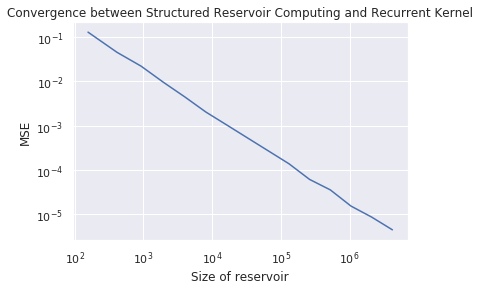

In [15]:
plt.loglog(n_res_range, error_src_rbf.numpy())
plt.title('Convergence between Structured Reservoir Computing and Recurrent Kernel');
plt.xlabel('Size of reservoir')
plt.ylabel('MSE')

In [16]:
np.save('out/200519_conv_src_rbf_len40_1e2to1e4', error_src_rbf)

# Acos and RC

In [19]:
n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
input_scale = 1  # variance of input
res_scale = 1 # variance of reservoir

RK = RecKernel(function='acos heaviside', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

# n_res_range = np.arange(start=100,stop=8000, step=1000)
n_res_range = np.logspace(2, 4.5, num=25, dtype=int)
error_rc_acos = torch.zeros(len(n_res_range))

with torch.no_grad():
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    #     K = computekernel.arcsin(input_data, initial_state, scale_res)
        K = RK.forward(input_data)
        X_final = torch.zeros((n_input,n_res)).to(device)
        for n_in in range(n_input):
            model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                                  f='heaviside', random_projection='gaussian')
            X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
            X_final[n_in,:] = X[-1,:]
            del X

        del model
        K_hat = torch.matmul(X_final,X_final.t())
        error_rc_acos[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

23it [06:13, 16.23s/it]


RuntimeError: CUDA out of memory. Tried to allocate 2.31 GiB (GPU 0; 10.76 GiB total capacity; 2.68 GiB already allocated; 110.19 MiB free; 9.80 GiB reserved in total by PyTorch)

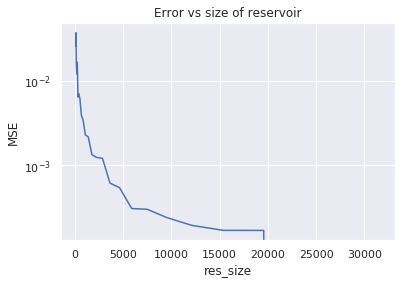

In [20]:
plt.semilogy(n_res_range, error_rc_acos.numpy())
plt.title('Error vs size of reservoir')
plt.ylabel('MSE')
plt.xlabel('res_size');

In [21]:
np.save('out/200519_conv_rc_acos_len40_1e2to1e45', error_rc_acos)

# RBF kernel and SRC

In [22]:
#arcsin kernel
n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
input_scale = 1  # variance of input
res_scale = 1 # variance of reservoir

RK = RecKernel(function='acos heaviside', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

# n_res_range = np.arange(start=10000,stop=100000, step=5000)
first_pow = 8
last_pow = 22  # 2**20 => ~10^6
n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
error_src_acos = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
#     K = computekernel.arcsin(input_data, initial_state, scale_res)
    K = RK.forward(input_data)
    X_final = torch.zeros((n_input,n_res)).to(device)
    
#     torch.manual_seed(1)
#     bias = 2 * np.pi * torch.rand(n_res).to(device)
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                          f='heaviside', random_projection='structured')
    for n_in in range(n_input):
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_src_acos[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

15it [00:15,  1.01s/it]


Text(0, 0.5, 'MSE')

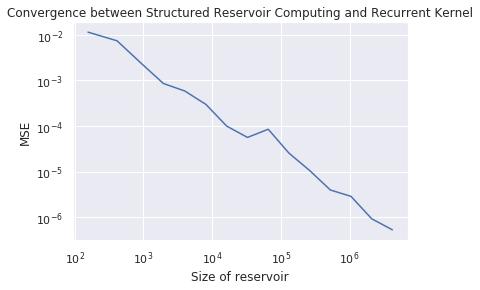

In [23]:
plt.loglog(n_res_range, error_src_acos.numpy())
plt.title('Convergence between Structured Reservoir Computing and Recurrent Kernel');
plt.xlabel('Size of reservoir')
plt.ylabel('MSE')

In [21]:
np.save('out/200519_conv_src_acos_len40_1e2to1e4', error_src_acos)

# Sign/Asin and RC

In [24]:
n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
input_scale = 1  # variance of input
res_scale = 1 # variance of reservoir

RK = RecKernel(function='asin sign', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

# n_res_range = np.arange(start=100,stop=8000, step=1000)
n_res_range = np.logspace(2, 4.5, num=25, dtype=int)
error_rc_asin2 = torch.zeros(len(n_res_range))

with torch.no_grad():
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    #     K = computekernel.arcsin(input_data, initial_state, scale_res)
        K = RK.forward(input_data)
        X_final = torch.zeros((n_input,n_res)).to(device)
        for n_in in range(n_input):
            model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                                  f='sign', random_projection='gaussian')
            X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
            X_final[n_in,:] = X[-1,:]
            del X

        del model
        K_hat = torch.matmul(X_final,X_final.t())
        error_rc_asin2[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

23it [06:10, 16.13s/it]


RuntimeError: CUDA out of memory. Tried to allocate 2.31 GiB (GPU 0; 10.76 GiB total capacity; 2.68 GiB already allocated; 110.19 MiB free; 9.80 GiB reserved in total by PyTorch)

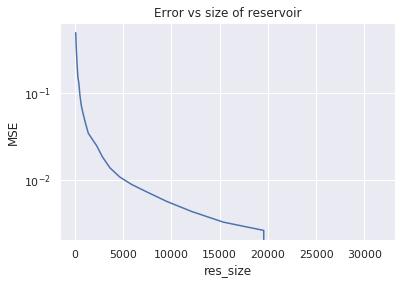

In [25]:
plt.semilogy(n_res_range, error_rc_asin2.numpy())
plt.title('Error vs size of reservoir')
plt.ylabel('MSE')
plt.xlabel('res_size');

In [26]:
np.save('out/200519_conv_rc_asin2_len40_1e2to1e45', error_rc_asin2)

# RBF kernel and SRC

In [27]:
#arcsin kernel
n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
input_scale = 1  # variance of input
res_scale = 1 # variance of reservoir

RK = RecKernel(function='asin sign', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

# n_res_range = np.arange(start=10000,stop=100000, step=5000)
first_pow = 8
last_pow = 22  # 2**20 => ~10^6
n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
error_src_asin2 = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
#     K = computekernel.arcsin(input_data, initial_state, scale_res)
    K = RK.forward(input_data)
    X_final = torch.zeros((n_input,n_res)).to(device)
    
#     torch.manual_seed(1)
#     bias = 2 * np.pi * torch.rand(n_res).to(device)
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                          f='sign', random_projection='structured')
    for n_in in range(n_input):
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_src_asin2[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

15it [00:14,  1.06it/s]


Text(0, 0.5, 'MSE')

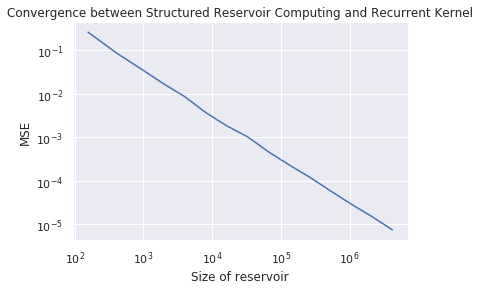

In [28]:
plt.loglog(n_res_range, error_src_asin2.numpy())
plt.title('Convergence between Structured Reservoir Computing and Recurrent Kernel');
plt.xlabel('Size of reservoir')
plt.ylabel('MSE')

In [29]:
np.save('out/200519_conv_src_asin2_len40_1e2to1e4', error_src_asin2)

# With leak rate

In [40]:
n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
input_scale = 1  # variance of input
res_scale = 1 # variance of reservoir
leak_rate = 0.5

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

RK = RecKernel(function='arcsin leak', res_scale=res_scale, input_scale=input_scale, 
               memory_efficient=False, leak_rate=leak_rate)
# n_res_range = np.arange(start=100,stop=8000, step=1000)
n_res_range = np.logspace(2, 3.5, num=15, dtype=int)
error_rc_asin = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    K = RK.forward(input_data)
    X_final = torch.zeros((n_input,n_res)).to(device)
    for n_in in range(n_input):
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f='erf', random_projection='gaussian', leak_rate=leak_rate)
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_rc_asin[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

15it [05:15, 21.02s/it]


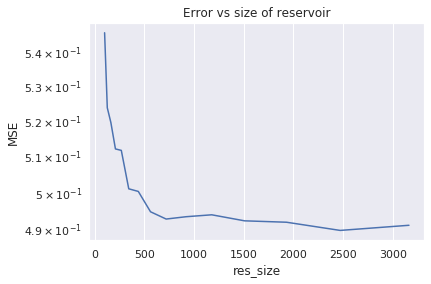

In [42]:
plt.semilogy(n_res_range, error_rc_asin.numpy())
plt.title('Error vs size of reservoir')
plt.ylabel('MSE')
plt.xlabel('res_size');

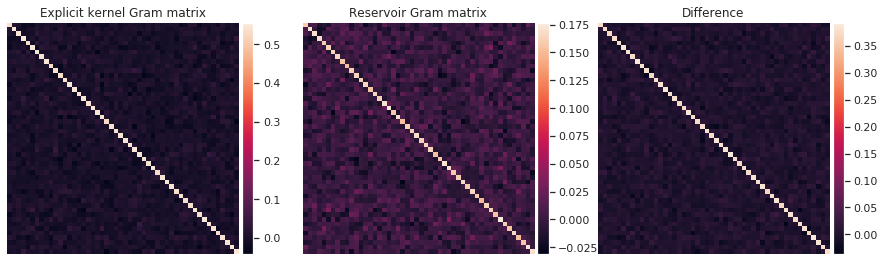

In [43]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

plot = axes[0].imshow(K.cpu().numpy())
axes[0].axis("off")
axes[0].set_title("Explicit kernel Gram matrix")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[1].imshow(K_hat.cpu().numpy())
axes[1].axis("off")
axes[1].set_title("Reservoir Gram matrix")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[2].imshow((K-K_hat).cpu().numpy())
axes[2].axis("off")
axes[2].set_title("Difference")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax);

In [45]:
print(K_hat[0,0])
print(K[0,0])

tensor(0.1619, device='cuda:0')
tensor(0.5396, device='cuda:0')


In [47]:
print(K_hat[0,2])
print(K[0,2])

tensor(0.0101, device='cuda:0')
tensor(0.0096, device='cuda:0')


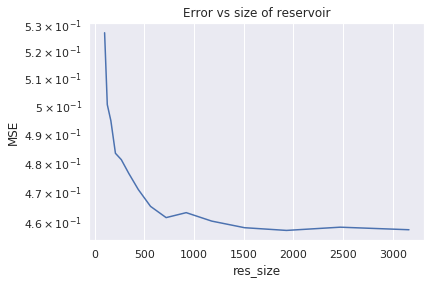

In [35]:
plt.semilogy(n_res_range, error_rc_asin.numpy())
plt.title('Error vs size of reservoir')
plt.ylabel('MSE')
plt.xlabel('res_size');

In [7]:
# np.save('out/200519_conv_rc_asin_len40_1e2to1e45', error_rc_asin)

# Arcsin and SRC

In [8]:
n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
input_scale = 1  # variance of input
res_scale = 1 # variance of reservoir

torch.manual_seed(123)
input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

RK = RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

# n_res_range = np.arange(start=10000,stop=100000, step=5000)
first_pow = 8
last_pow = 22  # 2**20 => ~10^6
n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
error_src_asin = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
#     K = computekernel.arcsin(input_data, initial_state, scale_res)
    K = RK.forward(input_data)
    X_final = torch.zeros((n_input,n_res)).to(device)
    for n_in in range(n_input):
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='erf', random_projection='structured')
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_src_asin[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

15it [00:24,  1.65s/it]


Text(0, 0.5, 'MSE')

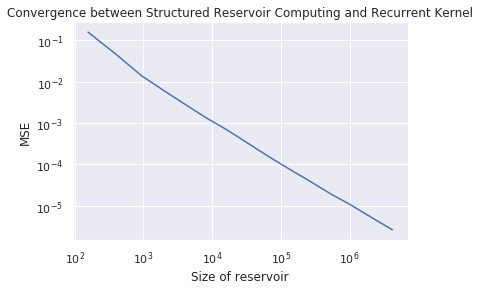

In [9]:
plt.loglog(n_res_range, error_src_asin.numpy())
plt.title('Convergence between Structured Reservoir Computing and Recurrent Kernel');
plt.xlabel('Size of reservoir')
plt.ylabel('MSE')

In [10]:
np.save('out/200519_conv_src_asin_len40_2p8to2p22', error_src_asin)